In [1]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

In [2]:
num_epochs = 100
batch_size = 128
latent_size = 2
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')


def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()

        self.encode = encoder
        self.decode = decoder

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.latent_size = latent_size

        self.fc = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_size)
        self.fc_logsigma = nn.Linear(400, latent_size)


    def forward(self, x): # pylint: disable=arguments-differ
        h = F.relu(self.fc(x))
        return self.fc_mu(h), self.fc_logsigma(h)

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self,latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, x): # pylint: disable=arguments-differ
        h = F.relu(self.fc1(x))
        return F.sigmoid(self.fc2(h))


In [16]:
model = VAE(Encoder(latent_size),Decoder(latent_size))

if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(size_average=False)

In [6]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.data.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.data.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './vae.pth')

Train Epoch: 0 [0/60000 (0%)]	Loss: 184.636520
Train Epoch: 0 [12800/60000 (21%)]	Loss: 49.224068
Train Epoch: 0 [25600/60000 (43%)]	Loss: 45.785324
Train Epoch: 0 [38400/60000 (64%)]	Loss: 44.793373
Train Epoch: 0 [51200/60000 (85%)]	Loss: 42.760319
====> Epoch: 0 Average loss: 48.8395
Train Epoch: 1 [0/60000 (0%)]	Loss: 43.010090
Train Epoch: 1 [12800/60000 (21%)]	Loss: 42.773026
Train Epoch: 1 [25600/60000 (43%)]	Loss: 43.042606
Train Epoch: 1 [38400/60000 (64%)]	Loss: 41.365921
Train Epoch: 1 [51200/60000 (85%)]	Loss: 39.806789
====> Epoch: 1 Average loss: 42.0314
Train Epoch: 2 [0/60000 (0%)]	Loss: 40.363647
Train Epoch: 2 [12800/60000 (21%)]	Loss: 43.199726
Train Epoch: 2 [25600/60000 (43%)]	Loss: 40.900299
Train Epoch: 2 [38400/60000 (64%)]	Loss: 40.525513
Train Epoch: 2 [51200/60000 (85%)]	Loss: 40.563690
====> Epoch: 2 Average loss: 40.7160
Train Epoch: 3 [0/60000 (0%)]	Loss: 41.085674
Train Epoch: 3 [12800/60000 (21%)]	Loss: 41.035469
Train Epoch: 3 [25600/60000 (43%)]	Loss: 

Train Epoch: 28 [25600/60000 (43%)]	Loss: 37.705544
Train Epoch: 28 [38400/60000 (64%)]	Loss: 36.566521
Train Epoch: 28 [51200/60000 (85%)]	Loss: 35.705410
====> Epoch: 28 Average loss: 37.0667
Train Epoch: 29 [0/60000 (0%)]	Loss: 34.597668
Train Epoch: 29 [12800/60000 (21%)]	Loss: 36.627563
Train Epoch: 29 [25600/60000 (43%)]	Loss: 34.610180
Train Epoch: 29 [38400/60000 (64%)]	Loss: 37.301926
Train Epoch: 29 [51200/60000 (85%)]	Loss: 36.485039
====> Epoch: 29 Average loss: 37.0246
Train Epoch: 30 [0/60000 (0%)]	Loss: 36.175640
Train Epoch: 30 [12800/60000 (21%)]	Loss: 38.572594
Train Epoch: 30 [25600/60000 (43%)]	Loss: 37.539856
Train Epoch: 30 [38400/60000 (64%)]	Loss: 35.496456
Train Epoch: 30 [51200/60000 (85%)]	Loss: 35.421818
====> Epoch: 30 Average loss: 36.9719
Train Epoch: 31 [0/60000 (0%)]	Loss: 36.752678
Train Epoch: 31 [12800/60000 (21%)]	Loss: 37.786228
Train Epoch: 31 [25600/60000 (43%)]	Loss: 35.105312
Train Epoch: 31 [38400/60000 (64%)]	Loss: 37.868759
Train Epoch: 31 [

Train Epoch: 56 [25600/60000 (43%)]	Loss: 37.960541
Train Epoch: 56 [38400/60000 (64%)]	Loss: 35.265434
Train Epoch: 56 [51200/60000 (85%)]	Loss: 35.232227
====> Epoch: 56 Average loss: 36.0403
Train Epoch: 57 [0/60000 (0%)]	Loss: 35.676365
Train Epoch: 57 [12800/60000 (21%)]	Loss: 34.861568
Train Epoch: 57 [25600/60000 (43%)]	Loss: 34.710903
Train Epoch: 57 [38400/60000 (64%)]	Loss: 34.664127
Train Epoch: 57 [51200/60000 (85%)]	Loss: 35.346542
====> Epoch: 57 Average loss: 36.0460
Train Epoch: 58 [0/60000 (0%)]	Loss: 37.849487
Train Epoch: 58 [12800/60000 (21%)]	Loss: 36.414867
Train Epoch: 58 [25600/60000 (43%)]	Loss: 37.262508
Train Epoch: 58 [38400/60000 (64%)]	Loss: 36.183739
Train Epoch: 58 [51200/60000 (85%)]	Loss: 36.068539
====> Epoch: 58 Average loss: 35.9845
Train Epoch: 59 [0/60000 (0%)]	Loss: 34.272682
Train Epoch: 59 [12800/60000 (21%)]	Loss: 37.618698
Train Epoch: 59 [25600/60000 (43%)]	Loss: 35.519127
Train Epoch: 59 [38400/60000 (64%)]	Loss: 33.617203
Train Epoch: 59 [

Train Epoch: 84 [25600/60000 (43%)]	Loss: 32.924992
Train Epoch: 84 [38400/60000 (64%)]	Loss: 34.602386
Train Epoch: 84 [51200/60000 (85%)]	Loss: 34.940460
====> Epoch: 84 Average loss: 35.5061
Train Epoch: 85 [0/60000 (0%)]	Loss: 37.887428
Train Epoch: 85 [12800/60000 (21%)]	Loss: 35.127377
Train Epoch: 85 [25600/60000 (43%)]	Loss: 34.783272
Train Epoch: 85 [38400/60000 (64%)]	Loss: 35.850750
Train Epoch: 85 [51200/60000 (85%)]	Loss: 35.887611
====> Epoch: 85 Average loss: 35.5171
Train Epoch: 86 [0/60000 (0%)]	Loss: 34.735374
Train Epoch: 86 [12800/60000 (21%)]	Loss: 38.050350
Train Epoch: 86 [25600/60000 (43%)]	Loss: 36.890251
Train Epoch: 86 [38400/60000 (64%)]	Loss: 32.586967
Train Epoch: 86 [51200/60000 (85%)]	Loss: 34.613224
====> Epoch: 86 Average loss: 35.4835
Train Epoch: 87 [0/60000 (0%)]	Loss: 36.397339
Train Epoch: 87 [12800/60000 (21%)]	Loss: 34.988686
Train Epoch: 87 [25600/60000 (43%)]	Loss: 36.200539
Train Epoch: 87 [38400/60000 (64%)]	Loss: 36.379929
Train Epoch: 87 [

In [26]:
model.load_state_dict(torch.load('vae.pth'))

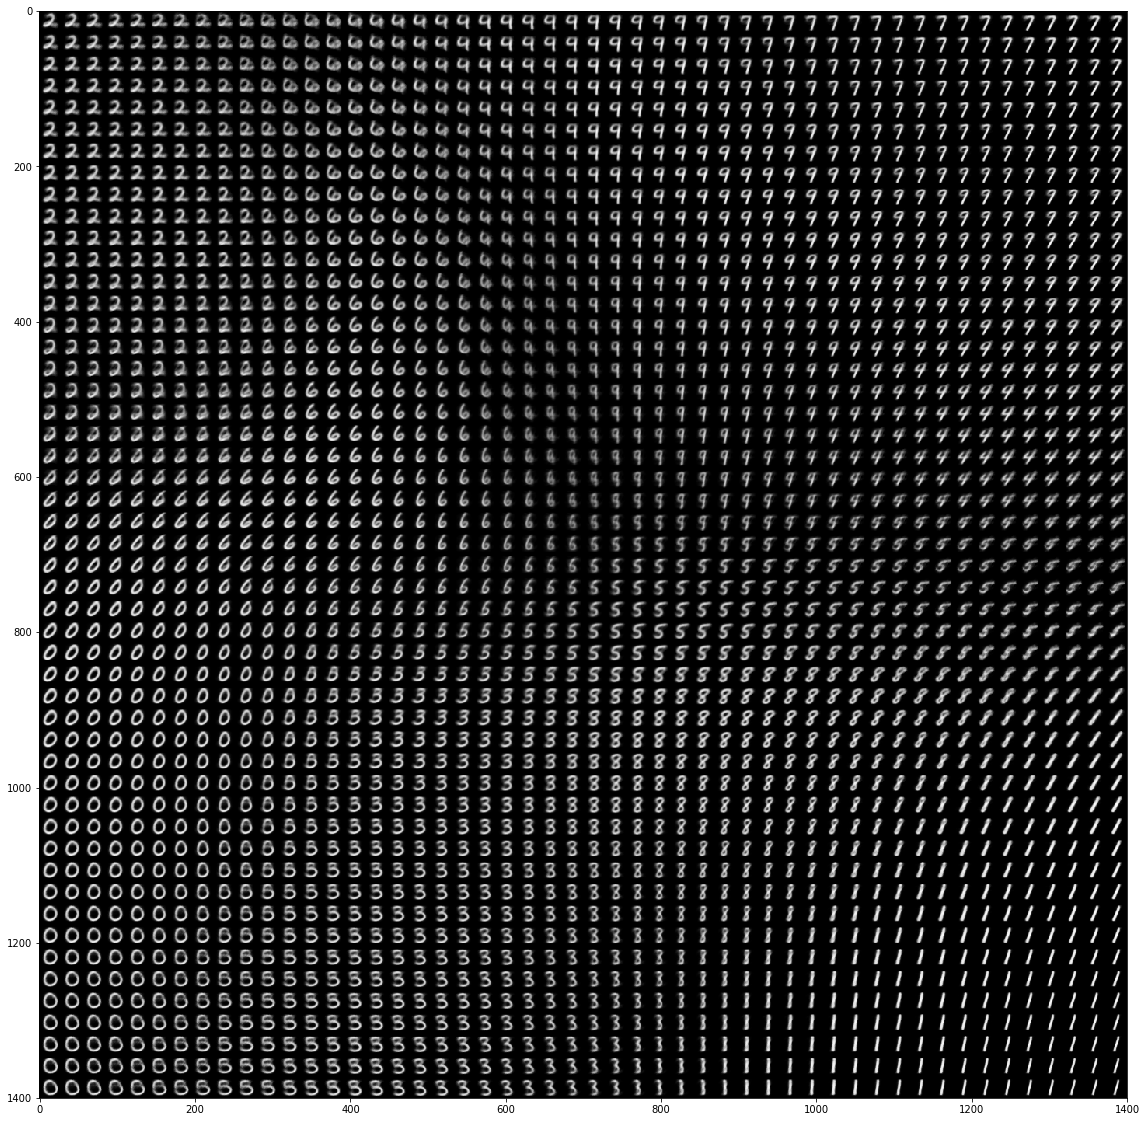

In [27]:
# Display a 2D manifold of the digits
n = 50  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
x = np.linspace(-1.5, 1.5, n)
y = np.linspace(-1.5, 1.5, n)
grid_x, grid_y = np.meshgrid(x,y)

t_x = torch.Tensor(grid_x).view(-1,1)
t_y = torch.Tensor(grid_y).view(-1,1)
t = torch.cat((t_x,t_y),dim=1)
samples = model.decode(t).detach().numpy().reshape(n,n,digit_size,digit_size)

# decode for each square in the grid
for i in range(n):
    for j in range(n):
        digit = samples[i][j]
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

In [28]:
def get_stats(model, dataloader):
    model.eval()
    stats = {}
    
    stats['mu'] = {}
    stats['mu']['mean']  = [[] for i in range(10)]
    stats['mu']['std']  = [[] for i in range(10)]
    stats['logsig'] = {}
    stats['logsig']['mean'] = [[] for i in range(10)]
    stats['logsig']['std']  = [[] for i in range(10)]
    
    mu_data = [[] for i in range(10)]
    logsig_data = [[] for i in range(10)]
    
    for idx,(images,labels) in enumerate(dataloader):
        mus,logsigmas = model.encode(images.view(images.size(0), -1))
        for mu, logsigma, label in zip(mus,logsigmas,labels):
            mu_data[label].append(list(mu.detach().cpu().numpy()))
            logsig_data[label].append(list(logsigma.detach().cpu().numpy()))
            

    for idx,vals in enumerate(mu_data):
        stats['mu']['mean'][idx] =  np.array(vals).mean(axis=0)
        stats['mu']['std'][idx] =  np.array(vals).std(axis=0)
    for idx,vals in enumerate(logsig_data):
        stats['logsig']['mean'][idx] = np.array(vals).mean(axis=0)
        stats['logsig']['std'][idx] = np.array(vals).std(axis=0)

    mean_mus  = np.array(stats['mu']['mean'])
    std_mus = np.array(stats['mu']['std'])
    mean_sigs = np.array(stats['logsig']['mean'])
    std_sigs = np.array(stats['logsig']['std'])
    
    return mean_mus,std_mus,mean_sigs,std_sigs

In [29]:
mean_mus, std_mus, mean_sigs, std_sigs = get_stats(model, dataloader)

In [30]:
#plt.scatter(mean_mus[:,0], mean_mus[:,1], marker = 'o',s = std_mus*1000, alpha = 0.5)
#plt.xlabel("mu")
#plt.ylabel("logsig")
#for label, x, y in zip(range(0,10), mean_mus[:,0], mean_mus[:,1]):
#    plt.annotate(
#        label,
#        xy=(x, y), 
#        xytext=(0, 0),
#        textcoords='offset points', 
#        ha='center', 
#        va='center'
#    )
#plt.show()

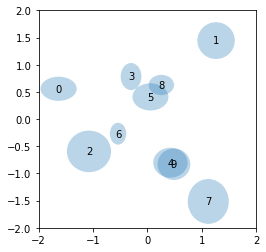

In [31]:
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ells = [Ellipse(xy= mus, width=w, height=h)
       for mus, (w,h) in zip(mean_mus,std_mus)]

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.3)
    #e.set_facecolor(np.random.rand(3))
    
for label, x, y in zip(range(0,10), mean_mus[:,0], mean_mus[:,1]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(0, 0),
        textcoords='offset points', 
        ha='center', 
        va='center'
)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

plt.show()